# Texture segmentation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2


from skimage import io, img_as_ubyte
from skimage.filters import threshold_otsu
from skimage.filters.rank import entropy
from skimage.morphology import disk
from scipy import ndimage

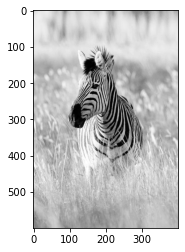

In [3]:
img = io.imread("../inpdata/images/zebra.jpg", as_gray=True)
plt.imshow(img, cmap="gray")

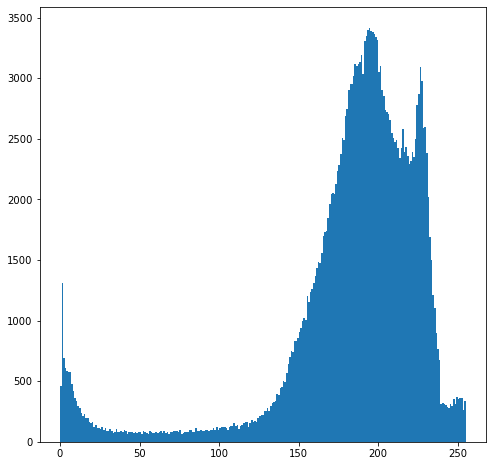

In [16]:
fig = plt.figure(figsize=(8, 8))
plt.hist(img_as_ubyte(img.flatten()), bins=255, range=(0, 255))
plt.show()

In [30]:
# Variance Calculation
kernel_size = 15
eimg = ndimage.uniform_filter(img, (kernel_size, kernel_size))
eimgsq = ndimage.uniform_filter(img ** 2, (kernel_size, kernel_size))
dimg = eimgsq - eimg ** 2

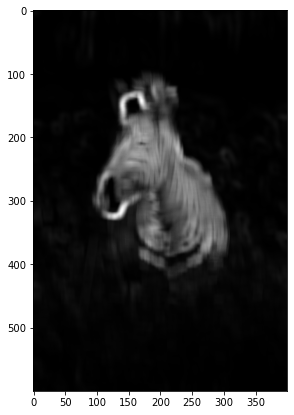

In [31]:
fig = plt.figure(figsize=(7, 7))
plt.imshow(dimg, cmap = "gray")

# Entropy

In [65]:
entropy_img = entropy(img_as_ubyte(img), disk(5))

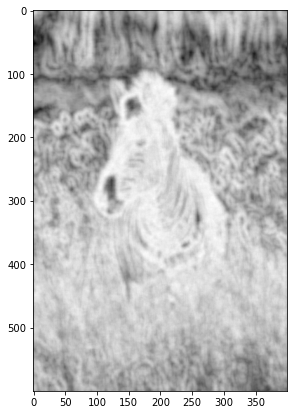

In [66]:
fig = plt.figure(figsize=(7, 7))
plt.imshow(entropy_img, cmap="gray")

In [67]:
thresh = threshold_otsu(entropy_img)

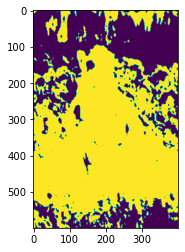

In [68]:
plt.imshow(np.digitize(entropy_img, bins=[thresh]))

# Scratch assay (wound healing) analysis